In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import PIL

In [2]:
image_size_=256
batch_size=32
channel=3


In [3]:
datset=tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle=True,
    image_size=(image_size_,image_size_),
    batch_size=batch_size
)

Found 16011 files belonging to 10 classes.


In [4]:
len(datset)

501

In [5]:
class_names=datset.class_names

In [6]:
# os.listdir('PlantVillage')

In [7]:
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [8]:
501*32

16032

In [9]:
for image_batch,label_batch in datset.take(1):
#     print(image_batch.shape)
#     print(label_batch.numpy())
    print(image_batch[0].numpy())

[[[140. 129. 127.]
  [104.  93.  91.]
  [151. 140. 138.]
  ...
  [150. 136. 135.]
  [123. 109. 108.]
  [139. 125. 124.]]

 [[167. 156. 154.]
  [127. 116. 114.]
  [125. 114. 112.]
  ...
  [140. 126. 125.]
  [106.  92.  91.]
  [132. 118. 117.]]

 [[115. 104. 102.]
  [118. 107. 105.]
  [125. 114. 112.]
  ...
  [131. 117. 116.]
  [138. 124. 123.]
  [152. 138. 137.]]

 ...

 [[162. 151. 155.]
  [172. 161. 165.]
  [151. 140. 144.]
  ...
  [163. 153. 152.]
  [152. 142. 141.]
  [164. 154. 153.]]

 [[177. 166. 170.]
  [189. 178. 182.]
  [173. 162. 166.]
  ...
  [173. 163. 162.]
  [163. 153. 152.]
  [163. 153. 152.]]

 [[173. 162. 166.]
  [189. 178. 182.]
  [189. 178. 182.]
  ...
  [193. 183. 182.]
  [188. 178. 177.]
  [178. 168. 167.]]]


# image_visualization

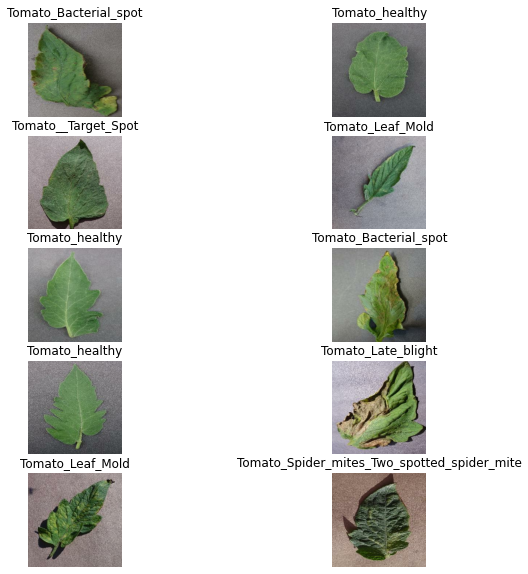

In [10]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in datset.take(1):
    for i in range(10):
        ax=plt.subplot(5,2,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

# data splitting
**80 % ==> training
20 % ==> 10% validation , 10 % test **


In [48]:
train_ds=datset.take(int(0.80*len(datset)))

In [14]:
len(train_ds)

400

In [11]:
0.80*len(datset)

400.8

In [12]:
val_test=datset.skip(int(0.80*len(datset)))

In [13]:
len(val_test)

101

In [14]:
val_ds=val_test.take(int(0.50 * (len(val_test))))

In [15]:
len(val_ds)

50

In [16]:
test_ds=val_test.skip(50)

In [17]:
len(test_ds)

51

In [18]:
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

400
51
50


In [11]:
def get_dataset_partitions(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split* ds_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [12]:
train_ds,val_ds,test_ds=get_dataset_partitions(datset)

In [13]:
len(train_ds)

400

In [14]:
len(val_ds)

50

In [15]:
len(test_ds)

51

In [16]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
resize_and_rescale=tf.keras.Sequential([
    
    layers.experimental.preprocessing.Resizing(image_size_,image_size_),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [18]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

# model building

In [24]:
input_shape=(batch_size,image_size_,image_size_,channel)
n_classes=10

model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
#     CNN
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(80, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
#     ANN
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [25]:
model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
his=model.fit(train_ds,
         epochs=10,
         batch_size=batch_size,
         verbose=1,
         validation_data=val_ds)

Epoch 1/10
250/400 [=================>............] - ETA: 7:10 - loss: 1.9127 - accuracy: 0.3107

# i think that i need to use the transfer learning to build the model becuase my model is taking too much time to train 

In [20]:
import tensorflow_hub as hub
from tensorflow import keras

In [21]:
feature_extractor_model="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
pre_model_without_top_layer=hub.KerasLayer(feature_extractor_model,input_shape=(32,224,224,3),trainable=False)

In [22]:
num_f=10
model=keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    pre_model_without_top_layer,
    keras.layers.Dense(num_f,activation='softmax')
    
])

In [54]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [55]:
# Early stopping and model check point
from keras . callbacks import ModelCheckpoint,EarlyStopping

# early stopping
es=EarlyStopping(monitor='val_accuracy',min_delta=0.01,patience=3,verbose=1)


# model check point
mc=ModelCheckpoint(monitor='val_accuracy',filepath='./bestmodel.h5',verbose=1,save_best_only=True)

cd=[es,mc]

In [57]:
history=model.fit(train_ds,
         epochs=20,
         batch_size=batch_size,
         verbose=1,
         validation_data=val_ds,
)

Epoch 1/20
400/400 [==============================] - 598s 1s/step - loss: 0.7928 - accuracy: 0.7496 - val_loss: 0.5904 - val_accuracy: 0.8069
Epoch 2/20
400/400 [==============================] - 553s 1s/step - loss: 0.4617 - accuracy: 0.8533 - val_loss: 0.4827 - val_accuracy: 0.8381
Epoch 3/20
400/400 [==============================] - 649s 2s/step - loss: 0.3971 - accuracy: 0.8713 - val_loss: 0.4400 - val_accuracy: 0.8438
Epoch 4/20
400/400 [==============================] - 717s 2s/step - loss: 0.3668 - accuracy: 0.8776 - val_loss: 0.3902 - val_accuracy: 0.8650
Epoch 5/20
400/400 [==============================] - 777s 2s/step - loss: 0.3312 - accuracy: 0.8920 - val_loss: 0.3943 - val_accuracy: 0.8594
Epoch 6/20
400/400 [==============================] - 791s 2s/step - loss: 0.3118 - accuracy: 0.8983 - val_loss: 0.3634 - val_accuracy: 0.8769
Epoch 7/20
400/400 [==============================] - 878s 2s/step - loss: 0.2981 - accuracy: 0.9003 - val_loss: 0.3452 - val_accuracy: 0.8794

In [23]:
# model.save('tomato/')

In [3]:
new_model = tf.keras.models.load_model('tomato/1')

In [ ]:
new_model.evaluate(test_ds)

In [24]:
import numpy as np

first image to predict
actual label: Tomato_Late_blight
predicted label: Tomato_Early_blight


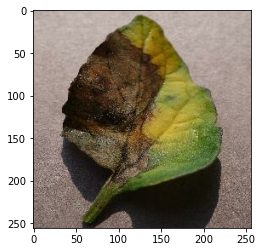

In [25]:
for image_batch,labels_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    print('actual label:', class_names[first_label])
    
    batch_pred=new_model.predict(image_batch)
    print('predicted label:', class_names[np.argmax(batch_pred[0])])
    
    
    

# predict function 

In [2]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    print(img_array)
    predictions=model.predict(img_array)
    
    predict_class=class_names[np.argmax(predictions[0])]
    confidence=round(100 * (np.max(predictions[0])),2)
    return predict_class,confidence

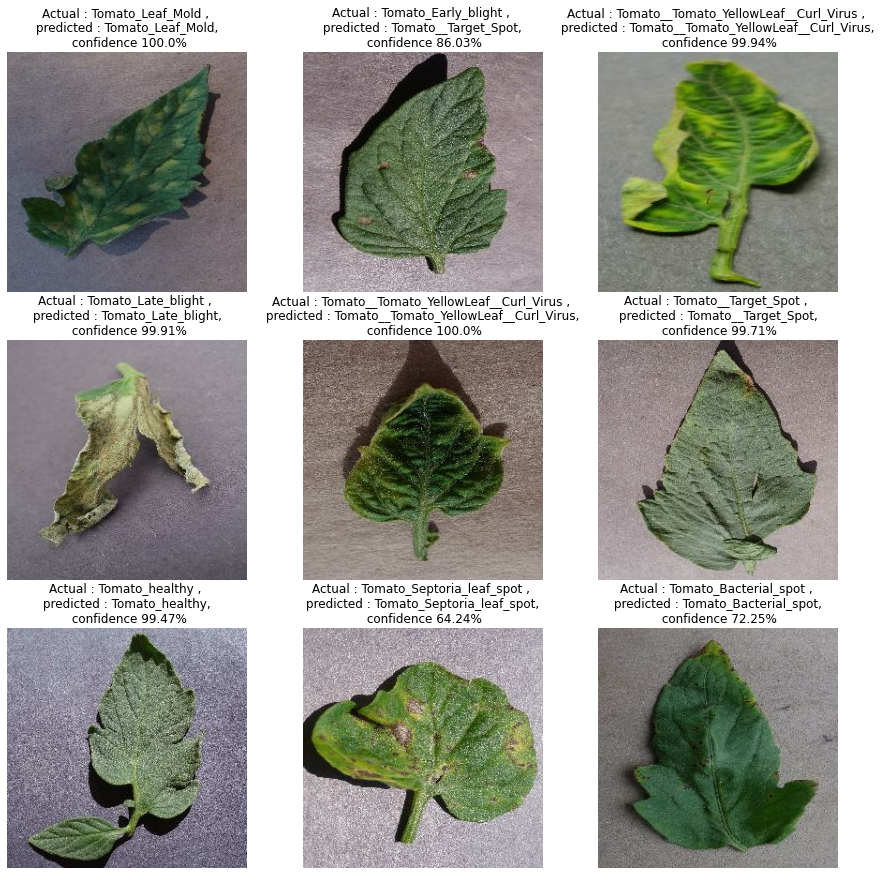

In [27]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        pred_class,confi=predict(new_model,images[i].numpy())
        actual_clas=class_names[labels[i]]
        plt.title(f'Actual : {actual_clas} , \n predicted : {pred_class}, \n confidence {confi}%')
        plt.axis('off')
        
        